# NBA: Post-Match Analysis

## Table of Contents 

- [Goals and objectives](#Goals) 
- [Data](#data)
    - [Load the data](#loaddata)
- [Exploratory Data Analysis (EDA)](#EDA)    
    - [Score Progression and Lead Differential](#score)
    - [Scoring Efficiency](#scoring)
    - [Rebounding Battle](#rebound)
    - [Turnover Analysis](#turnover)
    - [Player Efficiency (Plus-Minus Analysis)](#per)
- [Conclusions](#conclusion)

# Goals and Objectives <a class="anchor" id="Goals"></a>

The aim of this post-match analysis was to breakdown an NBA game, uncovering key insights that highlight both individual and team contributions to the result. This analysis aims to deliver these insights as the first step for understanding the game's dynamics, identifying the impact of players, and assessing areas of strength and weakness.

# Data <a class="anchor" id="data"></a>

The data for this analysis was obtained using the NBA API client package, which connects directly to NBA.com’s official data sources. This allows us to access detailed game, player, and team information from NBA.com, ensuring that the analysis is based on accurate and up-to-date data provided by the league itself.

## Load the Data <a class="anchor" id="loaddata"></a>

In [6]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import playbyplayv2, leaguegamefinder, boxscoretraditionalv2, boxscoreadvancedv2
from matplotlib.lines import Line2D

# Set Up Game Details
game_id = '0042300173'

# Load Game Data
pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
pbp_data = pbp.get_data_frames()[0]
boxscore_trad = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
trad_stats = boxscore_trad.get_data_frames()[0]
boxscore_adv = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=game_id)
adv_stats = boxscore_adv.get_data_frames()[0]
team_data = boxscore_trad.get_data_frames()[1]

# Extract Team Names
home_team = team_data.iloc[0]['TEAM_ABBREVIATION']
away_team = team_data.iloc[1]['TEAM_ABBREVIATION']

# Helper Function: Convert Time to Cumulative Minutes
def calculate_cumulative_minutes(period, pctimestring):
    minutes, seconds = map(int, pctimestring.split(':'))
    return (period - 1) * 12 + (11 - minutes) + (60 - seconds) / 60

# Exploratory Data Analysis (EDA) <a class="anchor" id="EDA"></a>

## Score Progression and Lead Differential <a class="anchor" id="score"></a>

This analysis provides a timeline of the game’s score progression for each team, highlighting lead changes and the periods during which one team held an advantage. The shaded area between the lines visually emphasised the magnitude of the lead at various points in the game. This  helps identify critical moments when momentum shifted.

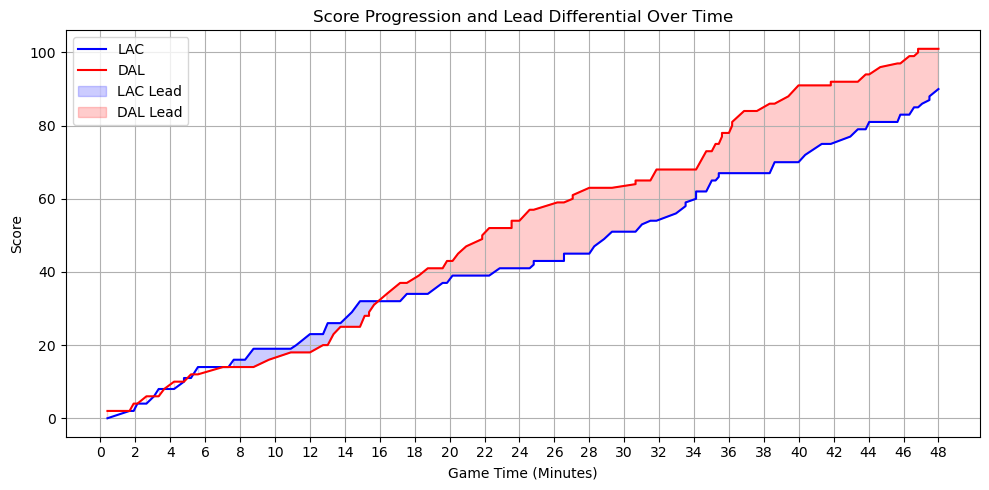

<Figure size 640x480 with 0 Axes>

In [9]:
scoring_plays = pbp_data[pbp_data['SCORE'].notna()].copy()
scoring_plays['HOME_SCORE'] = scoring_plays['SCORE'].apply(lambda x: int(x.split('-')[0]))
scoring_plays['AWAY_SCORE'] = scoring_plays['SCORE'].apply(lambda x: int(x.split('-')[1]))
scoring_plays['CUMULATIVE_MINUTES'] = scoring_plays.apply(
    lambda row: calculate_cumulative_minutes(row['PERIOD'], row['PCTIMESTRING']), axis=1)

plt.figure(figsize=(10, 5))
plt.plot(scoring_plays['CUMULATIVE_MINUTES'], scoring_plays['HOME_SCORE'], label=home_team, color='blue')
plt.plot(scoring_plays['CUMULATIVE_MINUTES'], scoring_plays['AWAY_SCORE'], label=away_team, color='red')
plt.fill_between(scoring_plays['CUMULATIVE_MINUTES'], scoring_plays['HOME_SCORE'], scoring_plays['AWAY_SCORE'],
                 where=(scoring_plays['HOME_SCORE'] > scoring_plays['AWAY_SCORE']), color='blue', alpha=0.2, label=f'{home_team} Lead')
plt.fill_between(scoring_plays['CUMULATIVE_MINUTES'], scoring_plays['HOME_SCORE'], scoring_plays['AWAY_SCORE'],
                 where=(scoring_plays['AWAY_SCORE'] > scoring_plays['HOME_SCORE']), color='red', alpha=0.2, label=f'{away_team} Lead')
plt.xticks(ticks=range(0, int(scoring_plays['CUMULATIVE_MINUTES'].max()) + 2, 2))
plt.xlabel('Game Time (Minutes)')
plt.ylabel('Score')
plt.title('Score Progression and Lead Differential Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Score progression.png", dpi=300)
plt.show()
plt.clf()

### Insights

We can see a relatively even game with a slight LA Clippers lead until 4 minutes into the 2nd quarter (minute 16 of the game). From here we see the Dallas Mavericks take the lead, increase it and maintain it. With around 4 minutes left to go in the 3rd quarter we can see that the LA Clippers make some defensive stops and decrease the gap between the two. Start of the 4th quarter Dallas makes some defensive stops, extends their lead and keeps it until game's end. 

Looking into the play-by-play around the 15th minute mark we see that a series of plays shifted the momentum of the game, including a Luka Doncic pull up, a steal, and a flagrant foul on the Mavericks which saw a 5 point swing in 30 seconds. 

## Scoring Efficiency <a class="anchor" id="scoring"></a>

Focused on identifying the starters and bench players scoring efficiency. Key metrics analysed include field goal percentage, 3-point percentage, and free throw percentage. This allows a comparison of scoring effectiveness among both teams' starting 5 players and players coming off the bench.

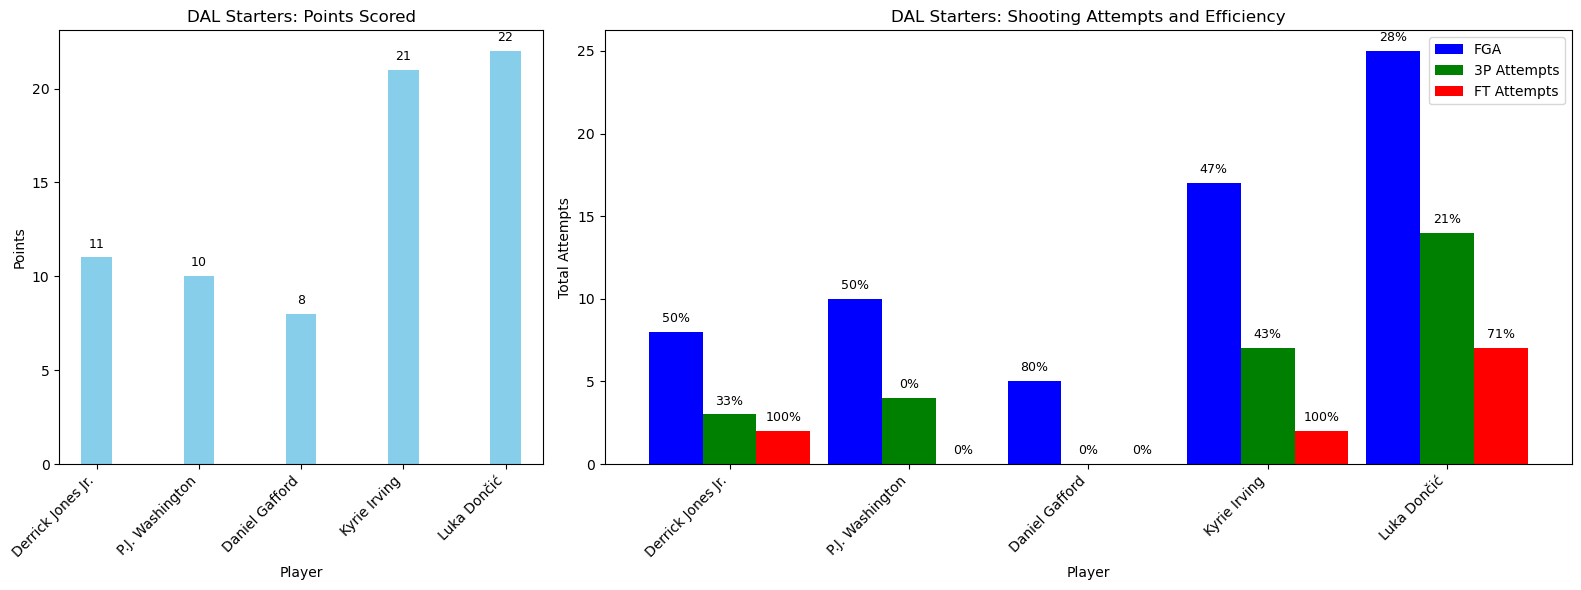

<Figure size 640x480 with 0 Axes>

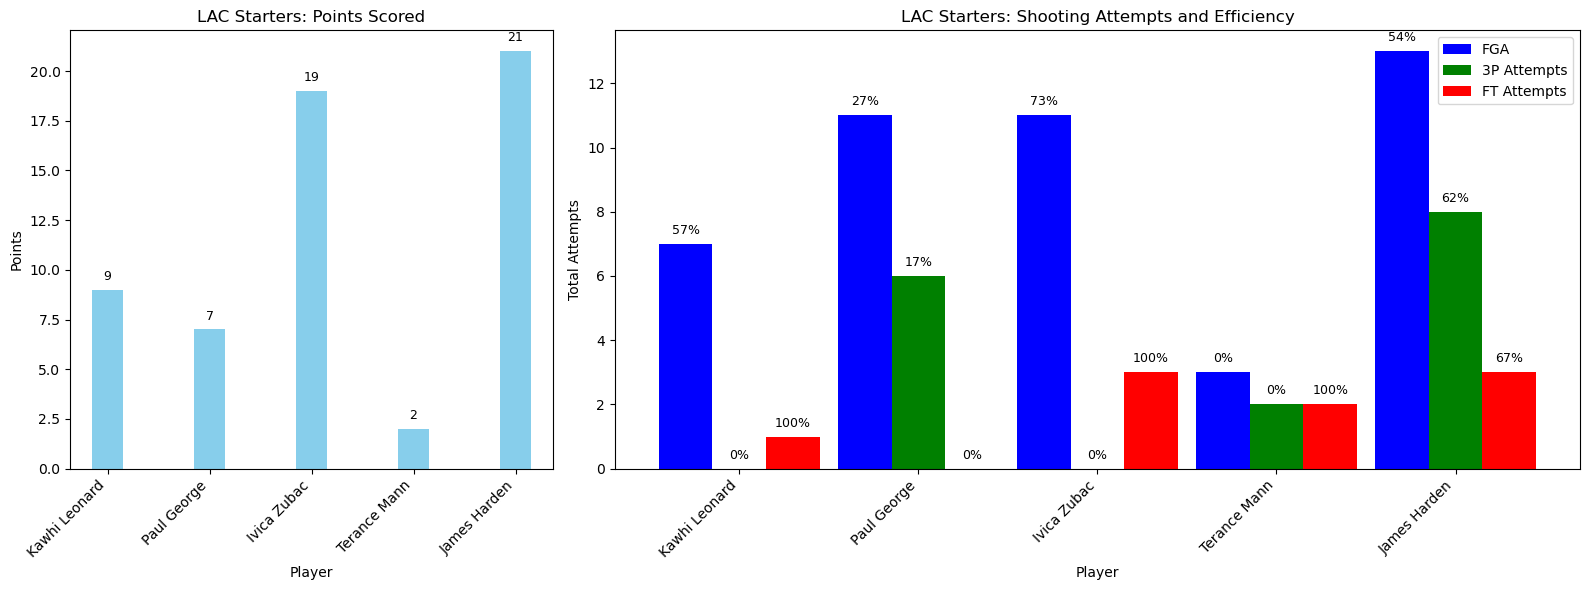

<Figure size 640x480 with 0 Axes>

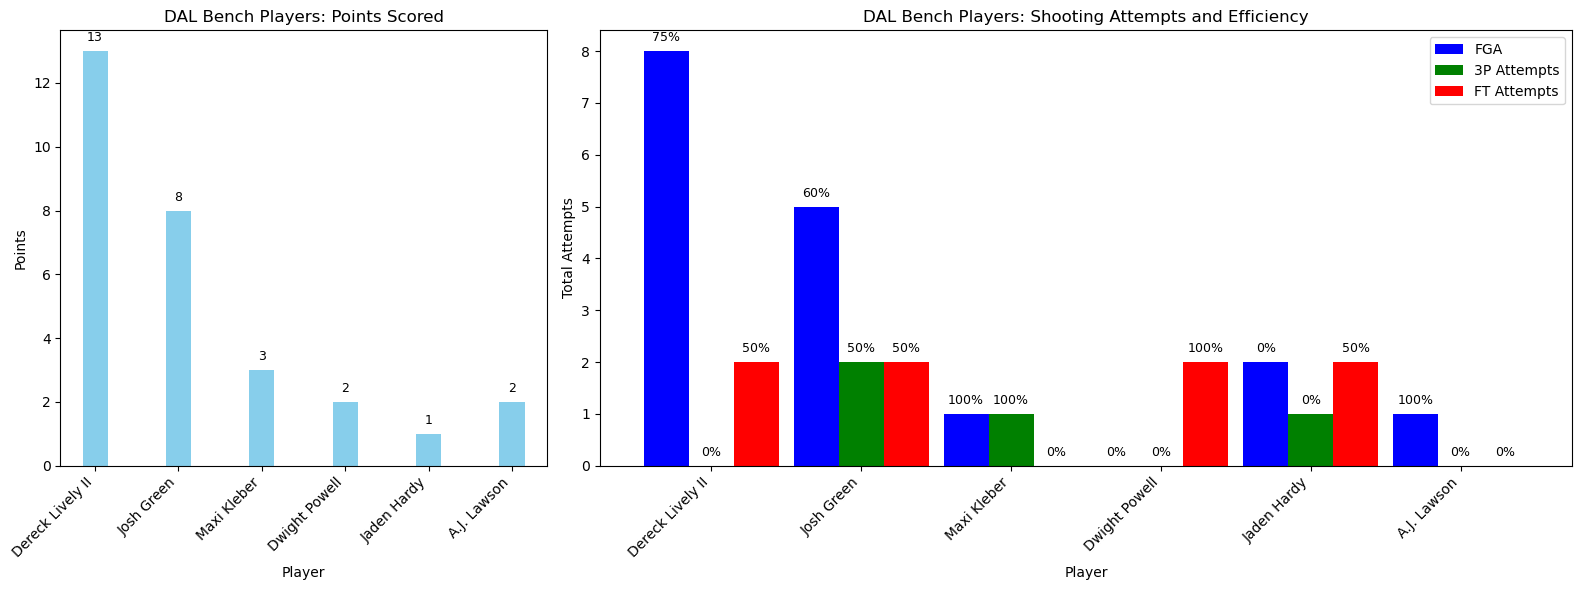

<Figure size 640x480 with 0 Axes>

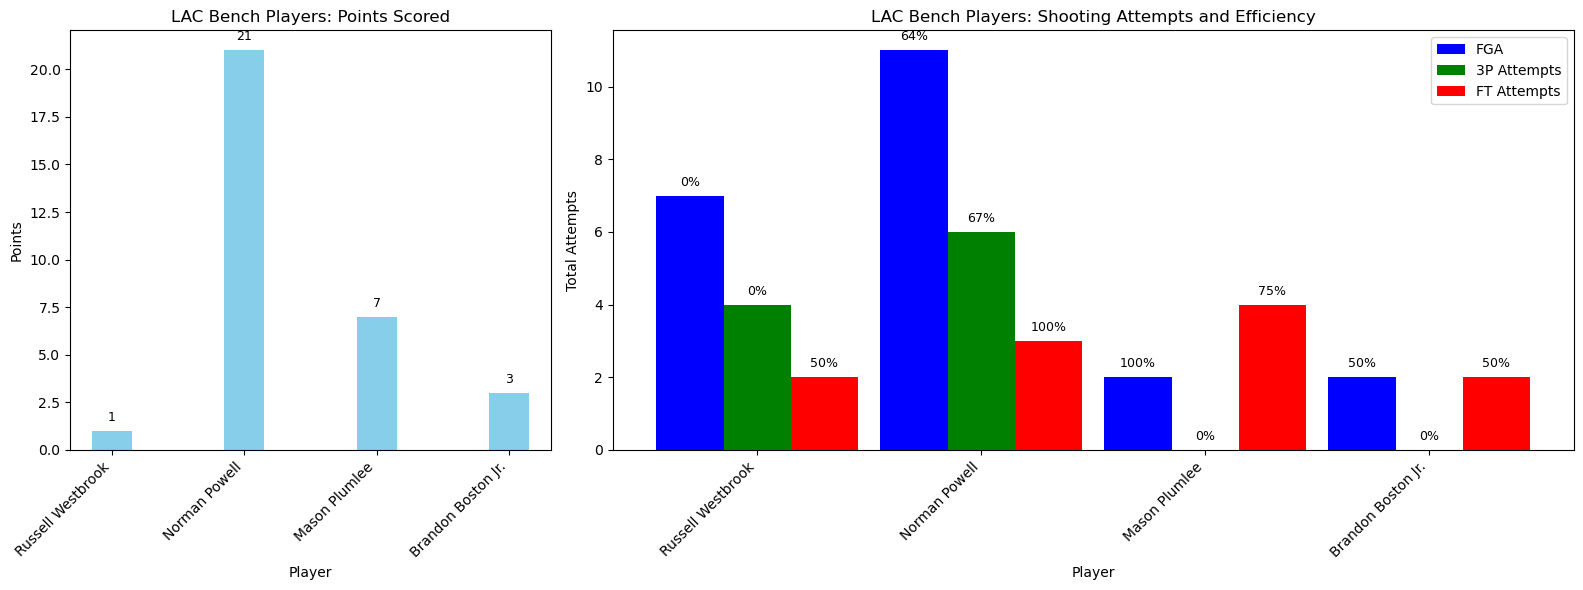

<Figure size 640x480 with 0 Axes>

In [12]:
# Calculate shooting efficiencies for starters
starters = trad_stats[trad_stats['START_POSITION'] != ''].copy()
starters['FG%'] = (starters['FGM'] / starters['FGA']).fillna(0)
starters['3P%'] = (starters['FG3M'] / starters['FG3A']).fillna(0)
starters['FT%'] = (starters['FTM'] / starters['FTA']).fillna(0)

# Group starters by team
teams = starters.groupby('TEAM_ABBREVIATION')

# Plot for each team (Starters)
for team, team_data in teams:
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})
    bar_width = 0.3
    positions = np.arange(len(team_data['PLAYER_NAME']))

    # Chart 1: Points Scored
    points_bars = ax[0].bar(positions, team_data['PTS'], width=bar_width, color='skyblue', label='Points')
    for bar in points_bars:
        height = bar.get_height()
        ax[0].annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    ax[0].set_xticks(positions)
    ax[0].set_xticklabels(team_data['PLAYER_NAME'], rotation=45, ha='right')
    ax[0].set_title(f'{team} Starters: Points Scored')
    ax[0].set_xlabel('Player')
    ax[0].set_ylabel('Points')

    # Chart 2: Shooting Efficiency and Attempts
    fg_bars = ax[1].bar(positions, team_data['FGA'], width=bar_width, color='blue', label='FGA')
    tp_bars = ax[1].bar(positions + bar_width, team_data['FG3A'], width=bar_width, color='green', label='3P Attempts')
    ft_bars = ax[1].bar(positions + 2 * bar_width, team_data['FTA'], width=bar_width, color='red', label='FT Attempts')

    for pos, (fg_pct, tp_pct, ft_pct) in enumerate(zip(team_data['FG%'] * 100, team_data['3P%'] * 100, team_data['FT%'] * 100)):
        ax[1].annotate(f'{fg_pct:.0f}%', xy=(positions[pos], team_data['FGA'].iloc[pos]),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        ax[1].annotate(f'{tp_pct:.0f}%', xy=(positions[pos] + bar_width, team_data['FG3A'].iloc[pos]),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        ax[1].annotate(f'{ft_pct:.0f}%', xy=(positions[pos] + 2 * bar_width, team_data['FTA'].iloc[pos]),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    ax[1].set_xticks(positions + bar_width)
    ax[1].set_xticklabels(team_data['PLAYER_NAME'], rotation=45, ha='right')
    ax[1].set_title(f'{team} Starters: Shooting Attempts and Efficiency')
    ax[1].set_xlabel('Player')
    ax[1].set_ylabel('Total Attempts')
    ax[1].legend()

    plt.tight_layout()
    fig.savefig(f"Score_Efficiency_{team}_Starters.png", dpi=300)
    plt.show()
    plt.clf()

# Repeat the same for bench players
bench_players = trad_stats[trad_stats['START_POSITION'] == ''].copy()
bench_players['FG%'] = (bench_players['FGM'] / bench_players['FGA']).fillna(0)
bench_players['3P%'] = (bench_players['FG3M'] / bench_players['FG3A']).fillna(0)
bench_players['FT%'] = (bench_players['FTM'] / bench_players['FTA']).fillna(0)

# Exclude players with Null in all shooting categories
bench_players = bench_players[
    bench_players['PTS'].notna() & ~((bench_players['FG%'] == 0) & (bench_players['3P%'] == 0) & (bench_players['FT%'] == 0))
]
teams_bench = bench_players.groupby('TEAM_ABBREVIATION')

for team, team_data in teams_bench:
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})
    bar_width = 0.3
    positions = np.arange(len(team_data['PLAYER_NAME']))

    # Chart 1: Points Scored
    points_bars = ax[0].bar(positions, team_data['PTS'], width=bar_width, color='skyblue', label='Points')
    for bar in points_bars:
        height = bar.get_height()
        ax[0].annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    ax[0].set_xticks(positions)
    ax[0].set_xticklabels(team_data['PLAYER_NAME'], rotation=45, ha='right')
    ax[0].set_title(f'{team} Bench Players: Points Scored')
    ax[0].set_xlabel('Player')
    ax[0].set_ylabel('Points')

    # Chart 2: Shooting Efficiency and Attempts
    fg_bars = ax[1].bar(positions, team_data['FGA'], width=bar_width, color='blue', label='FGA')
    tp_bars = ax[1].bar(positions + bar_width, team_data['FG3A'], width=bar_width, color='green', label='3P Attempts')
    ft_bars = ax[1].bar(positions + 2 * bar_width, team_data['FTA'], width=bar_width, color='red', label='FT Attempts')

    for pos, (fg_pct, tp_pct, ft_pct) in enumerate(zip(team_data['FG%'] * 100, team_data['3P%'] * 100, team_data['FT%'] * 100)):
        ax[1].annotate(f'{fg_pct:.0f}%', xy=(positions[pos], team_data['FGA'].iloc[pos]),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        ax[1].annotate(f'{tp_pct:.0f}%', xy=(positions[pos] + bar_width, team_data['FG3A'].iloc[pos]),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        ax[1].annotate(f'{ft_pct:.0f}%', xy=(positions[pos] + 2 * bar_width, team_data['FTA'].iloc[pos]),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    ax[1].set_xticks(positions + bar_width)
    ax[1].set_xticklabels(team_data['PLAYER_NAME'], rotation=45, ha='right')
    ax[1].set_title(f'{team} Bench Players: Shooting Attempts and Efficiency')
    ax[1].set_xlabel('Player')
    ax[1].set_ylabel('Total Attempts')
    ax[1].legend()

    plt.tight_layout()
    fig.savefig(f"Score_Efficiency_{team}_Bench.png", dpi=300)
    plt.show()
    plt.clf()


### Insights

This analysis shows that the Dallas starters had a greater scoring impact with a more balanced scoring distribution, putting pressure on the LA Clippers' bench players to step up and make a significant impact off the bench. Looking at both benches while Normal Powell had a standout performance as their 6th man the rest of the Clippers bench was not able to offset the poor shooting performance of their starters as Dallas' bench players also contributed significantly.

## Rebounding Battle <a class="anchor" id="rebound"></a>

Summarised total rebounds by each team, including offensive and defensive rebounds, and highlighted the players who led in rebounds. By examining team and individual rebounding efforts, this analysis provided insights into which team controlled the boards and how certain players contributed to second-chance opportunities through offensive rebounds. 

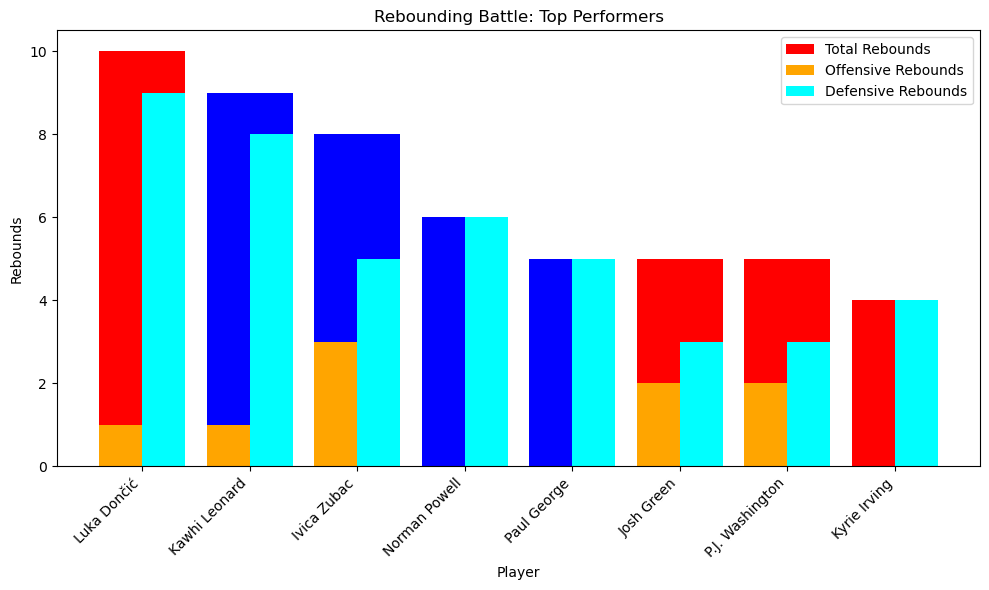

<Figure size 640x480 with 0 Axes>

In [15]:
rebounding_stats = trad_stats[['PLAYER_NAME', 'OREB', 'DREB', 'REB', 'TEAM_ABBREVIATION']].copy()
rebounding_stats = rebounding_stats.sort_values(by='REB', ascending=False).head(8)

fig, ax = plt.subplots(figsize=(10, 6))
positions = np.arange(len(rebounding_stats['PLAYER_NAME']))
team_colors = rebounding_stats['TEAM_ABBREVIATION'].map({home_team: 'blue', away_team: 'red'})

ax.bar(positions, rebounding_stats['REB'], label='Total Rebounds', color=team_colors)
ax.bar(positions - 0.2, rebounding_stats['OREB'], 0.4, label='Offensive Rebounds', color='orange')
ax.bar(positions + 0.2, rebounding_stats['DREB'], 0.4, label='Defensive Rebounds', color='cyan')

ax.set_xticks(positions)
ax.set_xticklabels(rebounding_stats['PLAYER_NAME'], rotation=45, ha='right')
ax.set_xlabel('Player')
ax.set_ylabel('Rebounds')
ax.set_title('Rebounding Battle: Top Performers')
ax.legend()
plt.tight_layout()
plt.savefig("Rebounding battle.png", dpi=300)
plt.show()
plt.clf()

### Insights

From the reuslts we can see that LA Clippers were more effective in the rebounding department (Confirmed with box score stats 41 to 36), with the key starters contributing the most. 

## Turnover Analysis <a class="anchor" id="turnover"></a>

Total turnovers for each team were aggregated, and individual players with the highest turnovers were identified, furthermore, we know how many points were scored off turnovers. Turnover analysis helps assess possession efficiency and identify players who may have struggled under defensive pressure. High turnover rates often indicate weaknesses that opponents could exploit.

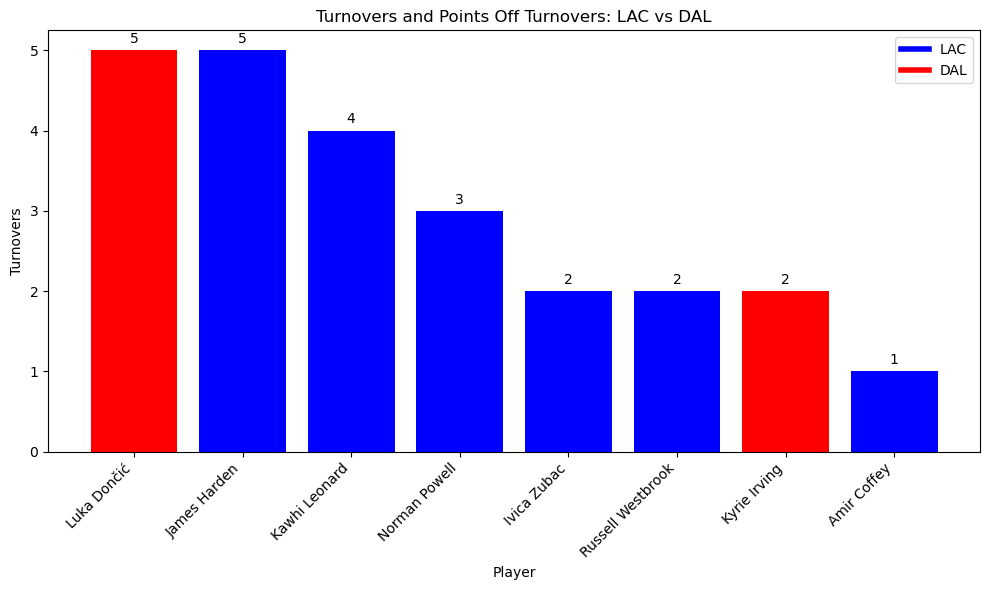

Points Off Turnovers:
LAC: 14 points
DAL: 26 points


<Figure size 640x480 with 0 Axes>

In [18]:
# Filter turnovers and scoring plays
turnover_plays = pbp_data[pbp_data['EVENTMSGTYPE'] == 5]  # Turnovers
scoring_plays = pbp_data[pbp_data['EVENTMSGTYPE'].isin([1, 3])]  # Field goals and free throws

# Calculate points off turnovers
points_off_turnovers = {}
for _, turnover in turnover_plays.iterrows():
    turnover_team = turnover['PLAYER1_TEAM_ABBREVIATION']
    scoring_team = None
    points_after_turnover = 0

    # Check the next 5 plays for scoring by the opposing team
    for _, play in pbp_data.loc[turnover.name + 1:turnover.name + 5].iterrows():
        if play['EVENTMSGTYPE'] in [1, 3]:  # Scoring event
            scoring_team = play['PLAYER1_TEAM_ABBREVIATION']
            if scoring_team != turnover_team:
                # Determine points scored
                if play['EVENTMSGTYPE'] == 1:  # Field goal
                    points_after_turnover += 3 if play['EVENTMSGACTIONTYPE'] == 1 else 2
                elif play['EVENTMSGTYPE'] == 3:  # Free throw
                    points_after_turnover += 1

    # Add points to the appropriate team
    if scoring_team and scoring_team in points_off_turnovers:
        points_off_turnovers[scoring_team] += points_after_turnover
    elif scoring_team:
        points_off_turnovers[scoring_team] = points_after_turnover

# Calculate turnovers per player
turnover_stats = trad_stats[['PLAYER_NAME', 'TO', 'TEAM_ABBREVIATION']].sort_values(by='TO', ascending=False).head(8)

# Visualise turnovers with points off turnovers per team
fig, ax = plt.subplots(figsize=(10, 6))
positions = np.arange(len(turnover_stats['PLAYER_NAME']))
team_colors = turnover_stats['TEAM_ABBREVIATION'].map({home_team: 'blue', away_team: 'red'})

# Bar chart of turnovers
bars = ax.bar(positions, turnover_stats['TO'], color=team_colors)

# Annotate bars with turnover counts
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Add labels, title, and legend
ax.set_xticks(positions)
ax.set_xticklabels(turnover_stats['PLAYER_NAME'], rotation=45, ha='right')
ax.set_xlabel('Player')
ax.set_ylabel('Turnovers')
ax.set_title(f'Turnovers and Points Off Turnovers: {home_team} vs {away_team}')
legend_elements = [Line2D([0], [0], color='blue', lw=4, label=home_team),
                   Line2D([0], [0], color='red', lw=4, label=away_team)]
ax.legend(handles=legend_elements)

# Show visualisation
plt.tight_layout()
plt.savefig("Turnovers.png", dpi=300)
plt.show()
plt.clf()

# Print the summary of points off turnovers
print(f"Points Off Turnovers:\n{home_team}: {points_off_turnovers.get(home_team, 0)} points\n"
      f"{away_team}: {points_off_turnovers.get(away_team, 0)} points")

### Insights

As we can see 6 of the 8 players with the highest turnover rate are Clippers players, half of them being starters. We have also extracted that there was a 12 point differential for the Mavericks on turnovers alone.

## Player Efficiency (Plus-Minus Analysis) <a class="anchor" id="per"></a>

The Plus-Minus metric was used to rank players by their on-court impact, reflecting how much each player contributed to scoring differential when they were on the floor. This analysis helps pinpoint the most influential players in terms of overall team success, highlighting who had a positive or negative impact beyond traditional scoring.

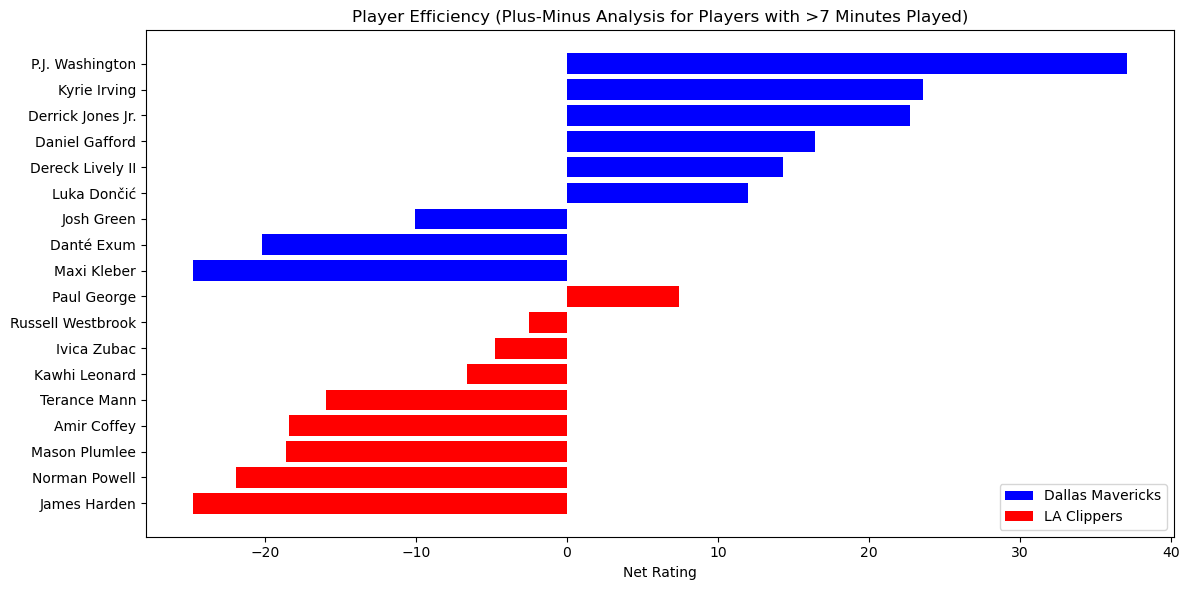

<Figure size 640x480 with 0 Axes>

In [21]:
# Define a function to parse minutes played
def parse_minutes(min_str):
    """
    Parses the 'MIN' column to calculate total minutes played as a float.
    Handles various formats and edge cases.
    """
    try:
        if pd.isna(min_str):  # Handle None or NaN values
            return 0
        if '.' in min_str and ':' in min_str:  # Handle format like "24.000000:32"
            minutes, seconds = min_str.split(':')
            minutes = int(float(minutes))  # Convert "24.000000" to integer 24
            seconds = int(seconds)
            return minutes + seconds / 60
        elif ':' in min_str:  # Standard "MM:SS" format
            minutes, seconds = map(int, min_str.split(':'))
            return minutes + seconds / 60
        else:  # Already a numeric format
            return float(min_str)
    except (ValueError, AttributeError):  # Handle unexpected cases gracefully
        return 0

# Parse the 'MIN' column to calculate minutes played
adv_stats['MINUTES_PLAYED'] = adv_stats['MIN'].apply(parse_minutes)

# Filter for players who played more than 7 minutes
filtered_efficiency_stats = adv_stats[adv_stats['MINUTES_PLAYED'] > 7][['PLAYER_NAME', 'NET_RATING', 'MINUTES_PLAYED', 'TEAM_ABBREVIATION']].copy()

# Check if there are players left to plot
if not filtered_efficiency_stats.empty:
    # Sort by Net Rating for a clearer visualisation
    filtered_efficiency_stats = filtered_efficiency_stats.sort_values(by='NET_RATING', ascending=False)

    # Separate players by team for visual differentiation
    dallas_players = filtered_efficiency_stats[filtered_efficiency_stats['TEAM_ABBREVIATION'] == 'DAL']
    clippers_players = filtered_efficiency_stats[filtered_efficiency_stats['TEAM_ABBREVIATION'] == 'LAC']

    # Plot the filtered efficiency stats
    plt.figure(figsize=(12, 6))
    bar_width = 0.4

    # Plot Dallas players
    plt.barh(dallas_players['PLAYER_NAME'], dallas_players['NET_RATING'], color='blue', label='Dallas Mavericks')

    # Plot Clippers players
    plt.barh(clippers_players['PLAYER_NAME'], clippers_players['NET_RATING'], color='red', label='LA Clippers')

    # Add labels and title
    plt.xlabel('Net Rating')
    plt.title('Player Efficiency (Plus-Minus Analysis for Players with >7 Minutes Played)')
    plt.gca().invert_yaxis()  # Invert y-axis to align with ranking
    plt.legend(loc='lower right')  # Add legend to differentiate teams
    plt.tight_layout()
    plt.savefig("Player efficiency.png", dpi=300)
    plt.show()
    plt.clf()


### Insight

Here we can see the net plus-minus showing that although some of the LA Clippers were individually efficient in shooting, their overall effect on the game was negative. Paul George while having a quiet night for his standards was the only key Clippers player that was in the positive. 

## Conclusion <a class="anchor" id="conclusion"></a>

#### Key findings overview:
- #### Scoring Progression and Lead Differential
    - From this data we would further analyse game tape, particularly minute 15 where we observed a momentum shift and lead change to about half time. We should look at the players on the court, the match-ups, and any particular instances that may have altered the momentum of the game.
- #### Top Scorers and Shooting Efficiency
    - Starters: Furthemore, using this data we should dive deeper into the reasons Luka had poor efficiency, was it shot selection, the defence of LA Clippers, or just a bad day in the office, similiarly we should dive into why Leonard, Zubac and Harden were able to shoot the ball well so that we can ensure they can continue to run an optimised offence and take advantage of various situations.
    - Bench: Again, we should dive deeper into the bench players and see why they performed with high efficiency. Amongst some of the factors mentioned previously we should also look at the timing of the substitiuions, momentum of the game and match-ups.
- #### Rebounding Battle
    - This data tells us that rebounding was not the or one of the key factors that influenced the results.
- #### Turnover Analysis
    - We can confidently conclcude this is one of the key factors as to why the Clippers lost the game, as Mavericks had a +12 point differential when scoring off turnovers. I would dive into deeper analysis through game tape and understand what situations caused these turnovers, was it a defensive strategy from Dallas perhaps double teaming more often, or was it carelessness with possession by Clippers. 
- #### Player Efficiency (Plus-Minus Analysis)
    - Further analysis should be done on the key match-ups for the Clippers, along with addressing the turnover issue. Dallas's starting 5 dominated while on the court, while Lively II made a positive impact off the bench. Reviewing game tape they should analyse their key bench players, Josh Green and and Maxi Kleber while on the court, having said that it is not a huge concern. As far as the Clippers are concerned this could be the results of the large turnover gap also.